In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
import numpy as np
import pandas as pd
import glob

import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
def scatter_plt(
    data, x_var, y_var, flag_color, colors=['darkolivegreen','firebrick'], x_log=True
    , n_sample=None, smooth=False, frac=0.1, seed=123):
    """
    Scatter plot (x with log10)
    Param:
        - flag_color: name of binary variable to color points with
        - n_sample: size of sample or None
        - lowess: plot smooth curve or not
        - frac: lowess frac
    """
    if n_sample:
        data = data.sample(n_sample, random_state=seed)
    data_resto = data
    if flag_color:
        data_flag = data[data[flag_color] == 1]
        data_resto = data[data[flag_color] == 0]
    fig, ax = plt.subplots()
    if x_log:
        ax.set_xscale('log')
        ax.set_xlim(left=10, right=10**8)
    plt.scatter(x_var, y_var, linewidth=0, c=colors[0], s=4, data=data_resto)
    if flag_color:
        plt.scatter(x_var, y_var, linewidth=0, c=colors[1], s=30, data=data_flag)
    if smooth:
        x_data = data[x_var]
        if x_log:
            x_data = np.log10(data[x_var])
        smooth_data = lowess(data[y_var], x_data, frac=frac)
        x_smooth = smooth_data[:,0]
        if x_log:
            x_smooth = 10**smooth_data[:,0]
        line = ax.plot(
            x_smooth, smooth_data[:,1], color='black', lw=1.0, ls='--')
    ax.axhline(0, ls='--', color='gray', linewidth=0.5)
    plt.xlabel(x_var)
    plt.ylabel(y_var)
    return fig, ax


def boxplots_plt(data, x_var, y_var, bins, flag_points=None):
    """
    Cut x_var in bins and make one boxplot per bin
    Param:
        - flag_points: name of flag of points to plot
    """
    #data = data.sort_values("freq") # ordena por freq para pintar scatter rojo correctamente
    freq_bins = pd.cut(np.log10(data[x_var]), bins=bins)
    nobs = freq_bins.value_counts().values
    nobs = [str(x) for x in nobs.tolist()]
    nobs = ["n: " + i for i in nobs]
    fig, ax = plt.subplots()
    ax = sns.boxplot(x=freq_bins, y=data[y_var], showfliers=False)
    if flag_points:
        is_flag = data[flag_points] == 1
        bins_flag = freq_bins[is_flag]
        bins_flag_rank = stats.rankdata(bins_flag, method='max') - 1
        y_flag = data[y_var][is_flag]
        plt.scatter(
            bins_flag_rank, y_flag, linewidth=0, c='firebrick', s=40)
    ax.axhline(0, ls='--', color='black', linewidth=0.5)
    labels_ypos = ax.get_ylim()[1] + .005
    for i in range(len(nobs)):
        ax.text(
            i, labels_ypos, nobs[i], horizontalalignment='center', size='small'
            , color='black', weight='semibold')
    return fig, ax


def boxplots_and_scatter_plt(df_list, x_var, y_var, bins=[1,2,3,4,5,6,8]):
    """
    plot only new words over boxplot
    Boxplots are built with data of all df_list
    """
    # Boxplot
    data = pd.concat(df_list)
    freq_bins = pd.cut(np.log10(data[x_var]), bins=bins)
    nobs = freq_bins.value_counts().values / len(df_list)
    nobs = [str(int(x)) for x in nobs.tolist()]
    nobs = ["n: " + i for i in nobs]
    fig, ax = plt.subplots()
    ax.axhline(0, ls='-', color='black', linewidth=0.5)
    ax = sns.boxplot(
        x=freq_bins, y=data[y_var], showfliers=False, color="white", boxprops=dict(alpha=.3))
    # lines and dots
    for i in range(len(df_list)):
        data_nw = df_list[i].query("newword == 1")
        y_nw = data_nw[y_var]        
        bins_nw = pd.cut(np.log10(data_nw[x_var]), bins=bins)
        bins_new_left = [i.left for i in bins_nw]
        bins_nw_rank = bins_new_left - min(bins_new_left) # rank        
        plt.plot(bins_nw_rank, y_nw, color='gray', lw=1.0, ls='--')
        plt.scatter(bins_nw_rank, y_nw, linewidth=0.1, c='firebrick', s=30)
    # n labels
    labels_ypos = ax.get_ylim()[0] + .0005
    for i in range(len(nobs)):
        ax.text(
            i, labels_ypos, nobs[i], horizontalalignment='center', size='small'
            , color='black', weight='semibold')
    return fig, ax

#    ax.set_xscale('log')
#    ax.set_xlim(left=10, right=10**8)
#    ylims = np.quantile(df_list[0][y_var], [.001, .999]).tolist()
#    ax.set_ylim(ylims)
#    # plt.scatter(x_var, y_var, linewidth=0, c='white', s=1, data=df_list[0]) # para setear ylim con 1er dataset
#    ax.axhline(0, ls='--', color='gray', linewidth=0.5)
#    plt.xlabel(x_var)
#    plt.ylabel(y_var)

In [4]:
NEWWORDS = ['c'+str(i) for i in range(1,7)] # new context words

## Data

Usamos los sesgos calculados en 5 corpus -- en cada uno de ellos se agregaron 6 palabras de contexto al azar con diferentes órdenes de frecuencia y 2 palabras target con frecuencias similares a _he_ y _she_. 

In [5]:
# corpus ids of newwords corpora: 4,5,6,7,8
files_t1t2 = glob.glob("results/csv/biasbyword_full-C[4-8]_T1-T2.csv")
files_t1c5 = glob.glob("results/csv/biasbyword_full-C[4-8]_T1-C5.csv")
files_t1c4 = glob.glob("results/csv/biasbyword_full-C[4-8]_T1-C4.csv")
files_t1c3 = glob.glob("results/csv/biasbyword_full-C[4-8]_T1-C3.csv")
files_fk = glob.glob("results/csv/biasbyword_full-C[4-8]_FRENCH-KOREAN.csv")

In [6]:
%%time
# read
dfs_list = [
    [pd.read_csv(f) for f in files_t1t2]
    ,[pd.read_csv(f) for f in files_t1c5]
    ,[pd.read_csv(f) for f in files_t1c4]
    ,[pd.read_csv(f) for f in files_t1c3]
    ,[pd.read_csv(f) for f in files_fk]
]

Wall time: 1min 27s


In [7]:
# flag de new word
for dfs in dfs_list:
    for df in dfs:
        df['newword'] = np.where(df['word'].isin(NEWWORDS), 1, 0)

In [8]:
NAMES = ["T1/T2", "T1/C5", "T1/C4", "T1/C3", "FRENCH/KOREAN"]

## Plots

### word2vec

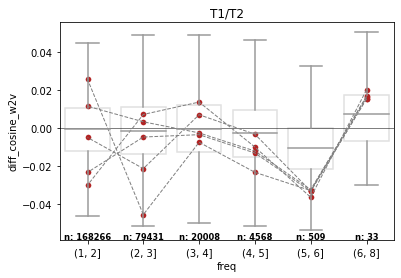

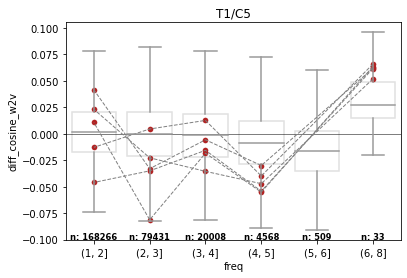

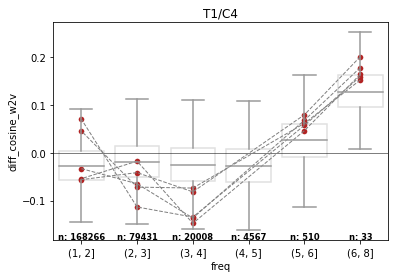

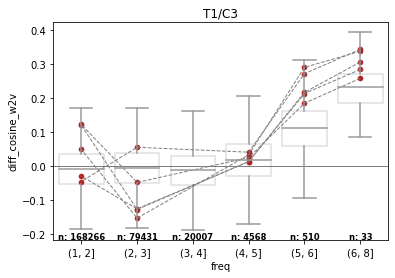

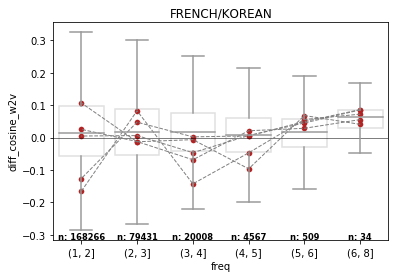

In [9]:
for dfs, name in zip(dfs_list, NAMES):
    fig_, ax_ = boxplots_and_scatter_plt(dfs, 'freq', 'diff_cosine_w2v')
    plt.title(name)

### GloVe

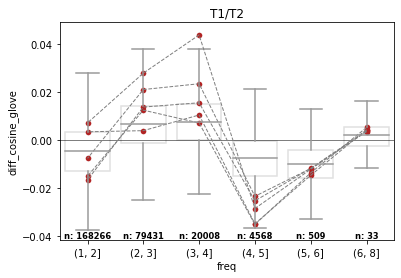

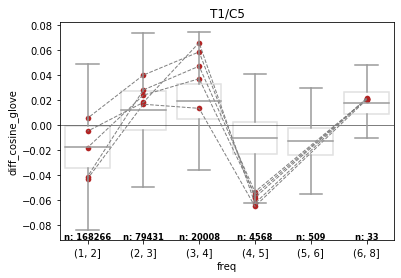

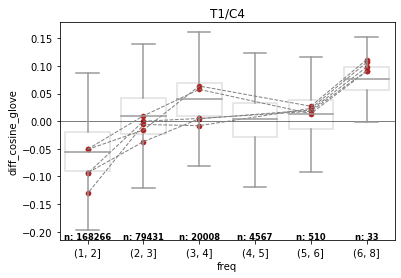

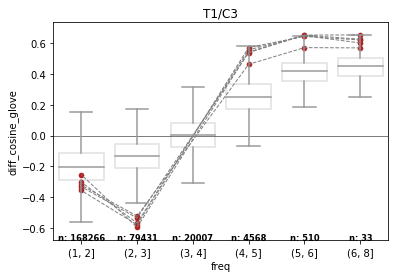

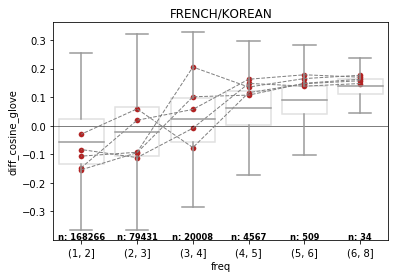

In [10]:
for dfs, name in zip(dfs_list, NAMES):
    fig_, ax_ = boxplots_and_scatter_plt(dfs, 'freq', 'diff_cosine_glove')
    plt.title(name)

### PPMI_vec

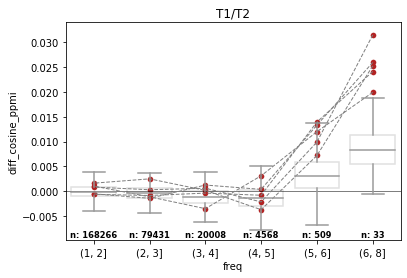

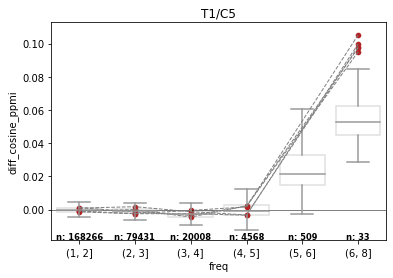

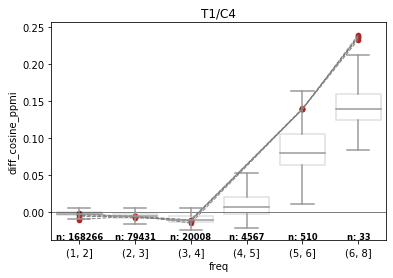

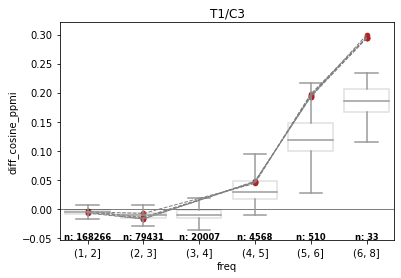

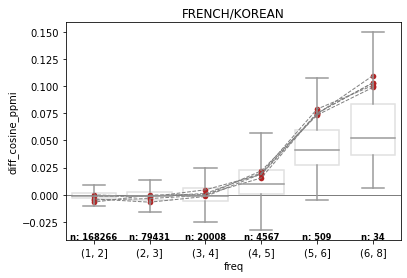

In [11]:
for dfs, name in zip(dfs_list, NAMES):
    fig_, ax_ = boxplots_and_scatter_plt(dfs, 'freq', 'diff_cosine_ppmi')
    plt.title(name)